In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import ResNet101_Weights
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

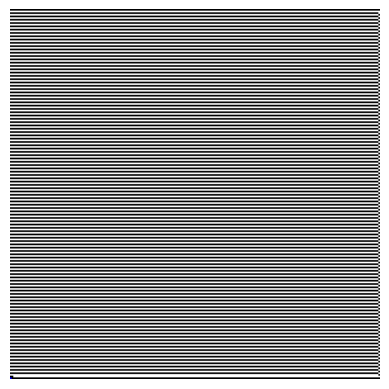

In [ ]:
# Load a pretrained model
model = models.resnet18(pretrained=True)
model.eval()

# Select a layer and neuron (e.g., first conv layer, first channel)
layer = model.conv1 
channel =  0


activation = None
def hook_fn(module, input, output):
    global activation
    activation = output

hook = layer.register_forward_hook(hook_fn)


image = torch.randn(1, 3, 224, 224, requires_grad=True)  # Random start
image = np.array(Image.open('sample.jpg'))
image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
image.requires_grad = True
optimizer = torch.optim.Adam([image], lr=0.1)

for i in range(100): 
    optimizer.zero_grad()
    model(image) 
    loss = -activation[0, channel].mean() 
    loss.backward()
    optimizer.step()

    image.data.clamp_(0, 1)  

hook.remove()


def show_image(tensor):
    img = tensor.detach().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image(image)


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\Haroon/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:30<00:00, 5.88MB/s] 


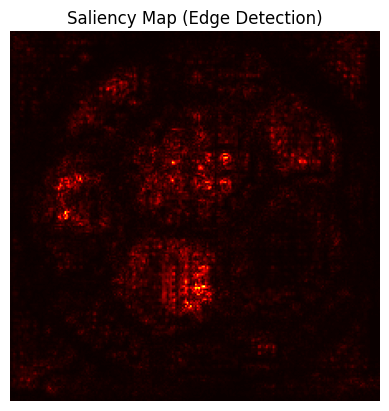

In [14]:


# Load a sample image
img_path = "sample.jpg"  
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_img = transform(img).unsqueeze(0)
input_img.requires_grad = True

# Forward pass
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
model.eval()
output = model(input_img)

# Compute saliency
output_idx = output.argmax()
output.max().backward()
saliency, _ = torch.max(input_img.grad.data.abs(), dim=1)

# Show saliency map
saliency = saliency.squeeze().numpy()
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.title("Saliency Map (Edge Detection)")
plt.show()


Step 0: Loss 0.8079490661621094
Step 50: Loss 0.3831479549407959
Step 100: Loss 0.3686036169528961
Step 150: Loss 0.36298882961273193


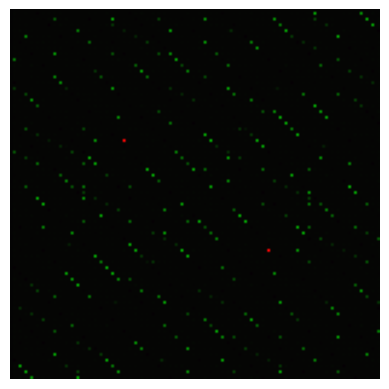

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models

# Load a pretrained VGG16 model
model = models.vgg16(pretrained=True).features.eval()

# Select an early convolutional layer (edge detectors)
layer = model[0]  # First Conv layer
filter_index = 10  # Change to explore different edge detectors

# Create Fourier-based image parameterization
def get_fourier_image(size):
    """Generate an image parameterized by Fourier coefficients"""
    freqs = torch.randn(1, 3, size, size, dtype=torch.float32, requires_grad=True)
    return freqs

def fourier_to_image(freqs):
    """Convert Fourier domain to image space"""
    img = torch.fft.ifft2(freqs).real
    img = (img - img.min()) / (img.max() - img.min())  # Normalize
    return img

# Initialize Fourier-space image
size = 128
freqs = get_fourier_image(size)
optimizer = torch.optim.Adam([freqs], lr=0.05, weight_decay=1e-4)

def total_variation_loss(img):
    """Encourage smoothness to prevent noise artifacts"""
    tv_h = torch.sum(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
    tv_w = torch.sum(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
    return (tv_h + tv_w) / img.numel()

# Optimization loop
for step in range(200):
    optimizer.zero_grad()

    img = fourier_to_image(freqs)
    img = img  # Add batch dimension

    output = layer(img)
    activation = output[0, filter_index].mean()
    
    loss = -activation + 1e-4 * total_variation_loss(img)  # Feature activation + regularization
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}: Loss {loss.item()}")

# Convert to NumPy and visualize
img_np = img.detach().squeeze().permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.axis('off')
plt.show()
